In this session, we are going to make practical use of what we just learned to explore a region of the genome, the RHD locus, which is responsible for the Rh antigen that can have an adverse effect during some pregnancies. This gene is located at chr1:25598977-25656936 in the hg19 version of the human genome reference sequence.

As with yesterday, set up imported packages and specific file locations

In [19]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import re
from pylab import plot,show
from scipy import stats
import os

baseDir='/scratch/biobootcamp_fluxod/remills/day4/read_counts_by_region'

fnSampleInfo = '%s/%s'%( baseDir, 'sample_info.txt' )
fnSampleList = '%s/%s'%( baseDir, 'sample_names.txt' )

#define region of interest
chromo = "1"
startPos = 25598977
endPos = 25656936
region = "1:25598977-25656936" #format needed for calling samtools

Let's take a quick look at the sample info file to check it's format

In [20]:
fileSampleInfo = open(fnSampleInfo,'r')
line = fileSampleInfo.readline()
fileSampleInfo.close()

line = line.rstrip()
line = line.split('\t')
line

['Sample',
 'Family ID',
 'Population',
 'Population Description',
 'Gender',
 'File Path']

Notice that this file is different from the one we used yesterday. It now includes an additional column, 'File Path', which gives an absolute location to the alignment file for each respective sample. As with yesterday, let's define a function to read through the file line by line and store the data for each sample and its file location into a dictionary

In [21]:
def parseSampleTable( filename ):
    fileSampTable = open(filename,'r')
    
    # skip past the file header
    fileSampTable.readline()

    samplePath={}
    samplePop={}
    
    # go line by line
    for line in fileSampTable:
        line = line.rstrip().split('\t')
        samplePath[ line[0] ] = line[5]
        samplePop[ line[0] ] = line[2]
    return samplePath, samplePop

Note how this function is almost identical to what we used yesterday. Reusing code is not only efficient but is recommended!

In [22]:
samplePath, samplePop = parseSampleTable( fnSampleInfo )

In [23]:
#example
sample = "HG00112"
samplePath[sample]
samplePop[sample]

'GBR'

Our goal now is to count the sequence reads at the RHD locus from each file and compare them.  We can do this using the *samtools* command we learned yesterday combined with the unix command *wc -l* which will count the number of lines printed to thes screen. We can call this program from within python using the *subprocess.call()* function

In [24]:
#construct command as if we would be running it from the command line. 
command = "samtools view " + samplePath[sample] + " " + region + " | wc -l > " + sample + ".cnt"
print command
subprocess.call(command, shell=True)

samtools view /scratch/data/1000genome/1000genomes/HG00112/alignment/HG00112.mapped.ILLUMINA.bwa.GBR.low_coverage.20120522.bam 1:25598977-25656936 | wc -l > HG00112.cnt


0

Each individual genome may be sequenced to different depths of coverage, leading to differences in read counts being a reflection of that depth rather than a true difference in sequence content. Thus, it would make sense to normalize by the total number of reads generated either for the whole genome or, as we will do here, for the chromosome of interest.

In [25]:
#Only need data for chromosome 1, so 'head -1' returns only the first line of the output that corresponds to chromo 1
#Number of aligned reads is in column 3, so we can 'cut' this column out and be left with only a single data point
command = "samtools idxstats " + samplePath[sample] + " | head -1 |cut -f 3 > " + sample + ".num"
print command
subprocess.call(command, shell=True)

samtools idxstats /scratch/data/1000genome/1000genomes/HG00112/alignment/HG00112.mapped.ILLUMINA.bwa.GBR.low_coverage.20120522.bam | head -1 |cut -f 3 > HG00112.num


0

However, with over 2500 sequences it would be inefficient (and boring!) to do all of them manually in this fashion. We could make use of cluster computing to run all 2500 simultaneously, however this would result in 2500 individual jobs that would need to be submitted, managed, and reviewed.

Instead, we can *batch* samples into smaller collections and send each batch as its own job. To do this, we will need to determine both **(a)** the number of batches we wish to submit and **(b)** the number of samples to include in each batch. For this exercise, we will construct batches of n=50.

In [26]:
numBatches = 50
#length of dictionary = number of samples here, can be calculated with len(dict)
numSamplesPerBatch = int(len(samplePath) / numBatches) + 1; #add one to round up if needed

#create a directory to store all the files
if not os.path.exists(baseDir + "/counts"):
    os.makedirs(baseDir + "/counts")

#create a directory to store PBS files
if not os.path.exists(baseDir + "/jobs"):
    os.makedirs(baseDir + "/jobs") 

#create a directory to store stdout and stderr files
if not os.path.exists(baseDir + "/logs"):
    os.makedirs(baseDir + "/logs") 

print len(samplePath)
print numSamplesPerBatch

2535
51


Then, we can use python to create individual PBS files for each batch and subsequently submit them to the cluster.

In [32]:
lastSampleNum = 0;
samples = samplePath.keys()

for batchNum in range (numBatches): #for each batch we plan to run

    #create new PBS file for submission, with corresponding header
    fileBatch = open(baseDir+"/jobs/batch"+str(batchNum)+".pbs", "w")
    fileBatch.write("#!/bin/bash\n") #shell line
    fileBatch.write("#\n")
    fileBatch.write("#PBS -N batch" + str(batchNum) + "\n") #name of job
    fileBatch.write("#PBS -o " + baseDir + "/logs/batch" + str(batchNum) + ".stdout\n") #stdout file
    fileBatch.write("#PBS -e " + baseDir + "/logs/batch" + str(batchNum) + ".stderr\n") #stderr file
    fileBatch.write("#PBS -l procs=1,qos=flux,mem=4gb,walltime=24:00:00\n") #feature line
    fileBatch.write("#PBS -m a\n") #message line, only send errors to email
    fileBatch.write("#PBS -M remills@umich.edu\n") #email line, to send messages from above
    fileBatch.write("#PBS -A biobootcamp_fluxod\n") #which account to associate job
    fileBatch.write("#PBS -q fluxod\n") #which queue to send job to 
    fileBatch.write("#PBS -V\n") #pass environmental variables to job
    fileBatch.write("#PBS -d .\n") #use current working directory
    fileBatch.write("\n") #use current working directory
    
    startIndex = lastSampleNum
    endIndex = lastSampleNum + numSamplesPerBatch
    
    #make sure last index is in range, in case batches aren't divided evenly
    if endIndex > len(samplePath): 
        endIndex = len(samplePath)
        
    for sampleNum in range (startIndex, endIndex):
        sample = samples[sampleNum] #current sample
        #write command for region counts
        command = "samtools view " + samplePath[sample] + " " + region + " | wc -l > " + baseDir + "/counts/" + sample + ".cnt"
        fileBatch.write(command+"\n")
        #write command for chromosome counts
        command = "samtools idxstats " + samplePath[sample] + " | head -1 | cut -f 3 > " + baseDir + "/counts/" + sample + ".num"
        fileBatch.write(command+"\n")
    fileBatch.close()
    
    #submit job to cluster
    subprocess.call(["qsub", baseDir+"/jobs/batch"+str(batchNum)+".pbs"]) 
    
    #update index for next iteration
    lastSampleNum = lastSampleNum + numSamplesPerBatch


Now we must wait for the jobs to finish. There are python modules which will check and sleep until all jobs are finalized. For simplicity, we can just manually check with the *qstat* command you were introduced to earlier (use your unique name instead of mine!).

In [44]:
!qstat -u remills


nyx.arc-ts.umich.edu: 
                                                                                  Req'd    Req'd       Elap
Job ID                  Username    Queue    Jobname          SessID  NDS   TSK   Memory   Time    S   Time
----------------------- ----------- -------- ---------------- ------ ----- ------ ------ --------- - ---------
16699387.nyx.arc-ts.um  remills     fluxod   batch0             2193   --       1  768mb  24:00:00 C       -- 
16699388.nyx.arc-ts.um  remills     fluxod   batch1             2197   --       1  768mb  24:00:00 C       -- 
16699389.nyx.arc-ts.um  remills     fluxod   batch2             2235   --       1  768mb  24:00:00 C       -- 
16699390.nyx.arc-ts.um  remills     fluxod   batch3             2266   --       1  768mb  24:00:00 C       -- 
16699391.nyx.arc-ts.um  remills     fluxod   batch4             2292   --       1  768mb  24:00:00 C       -- 
16699392.nyx.arc-ts.um  remills     fluxod   batch5             1791   --       1  768mb  24:0

This might take a few minutes to run. Once completed, we should take the time to do some quick checks of the stderr files to make sure that there were not  issues with any particular batch. This can be as simple as a quick *cat* of all the stderr files to see if anything is there. The lack of errors sent to your email address is also a sign that things went well.

In [45]:
!cat {baseDir}/logs/*stderr

Note well:

loading openmpi/1.6.0/gcc/4.4.6 and gcc/4.4.6 for Rmpi/snow

Note well:

loading openmpi/1.6.0/gcc/4.4.6 and gcc/4.4.6 for Rmpi/snow

Note well:

loading openmpi/1.6.0/gcc/4.4.6 and gcc/4.4.6 for Rmpi/snow

Note well:

loading openmpi/1.6.0/gcc/4.4.6 and gcc/4.4.6 for Rmpi/snow

Note well:

loading openmpi/1.6.0/gcc/4.4.6 and gcc/4.4.6 for Rmpi/snow

Note well:

loading openmpi/1.6.0/gcc/4.4.6 and gcc/4.4.6 for Rmpi/snow

Note well:

loading openmpi/1.6.0/gcc/4.4.6 and gcc/4.4.6 for Rmpi/snow

Note well:

loading openmpi/1.6.0/gcc/4.4.6 and gcc/4.4.6 for Rmpi/snow

Note well:

loading openmpi/1.6.0/gcc/4.4.6 and gcc/4.4.6 for Rmpi/snow

Note well:

loading openmpi/1.6.0/gcc/4.4.6 and gcc/4.4.6 for Rmpi/snow

Note well:

loading openmpi/1.6.0/gcc/4.4.6 and gcc/4.4.6 for Rmpi/snow

Note well:

loading openmpi/1.6.0/gcc/4.4.6 and gcc/4.4.6 for Rmpi/snow

Note well:

loading openmpi/1.6.0/gcc/4.4.6 and gcc/4.4.6 for Rmpi/snow

Note well:

loading openmpi/1.6.0/gcc/4.4.6 and gcc

Now, we can use python to read back in all the output files and construct a normalized list of sequence counts

In [46]:
samples = samplePath.keys()
rhdList = []
for sample in samples:
    #rhd counts
    cntFile = open(baseDir + "/counts/" + sample + ".cnt", "r")
    cnt = cntFile.readline()
    cnt = float(cnt.rstrip()) #float is important, otherwise will treat as STR or INT
    cntFile.close()
    
    #chromo 1 counts
    numFile = open(baseDir + "/counts/" + sample + ".num", "r")
    num = numFile.readline()
    num = float(num.rstrip())
    numFile.close()
    
    normCnt = 1e3 * (cnt / num) #scale for plotting
    rhdList.append(normCnt)


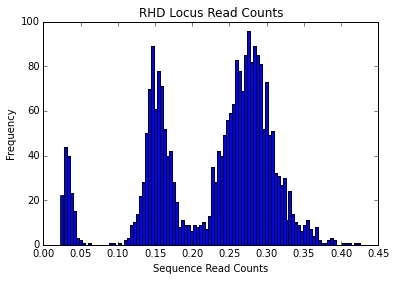

In [47]:
plt.hist(rhdList, bins=100)
plt.title("RHD Locus Read Counts")
plt.xlabel("Sequence Read Counts")
plt.ylabel("Frequency")
plt.show()

These results suggest that there are 3 classes of individuals with regards to the amount of sequence present at the RHD locus. What do you think those classes are?

Perhaps we are interested in a particular populations of individuals. If you recall from above, we also constructed a dictionary of populations from our sample info file. We can use python to print out all the unique values from that dictionary

In [49]:
s = set( val for dic in samplePop for val in samplePop.values())
print s

set(['ACB', 'CLM', 'BEB', 'PEL', 'LWK', 'MSL', 'GBR', 'IBS', 'ASW', 'TSI', 'KHV', 'CEU', 'YRI', 'CHB', 'GWD', 'STU', 'CHS', 'ESN', 'FIN', 'GIH', 'PJL', 'MXL', 'ITU', 'CDX', 'JPT', 'PUR'])


Let's focus in on the CEU and JPT populations. We can re-use the code from above, adding in a simple check to whether the population for a sample matches these values

In [54]:
samples = samplePath.keys()
rhdListCEU = []
rhdListJPT = []

for sample in samples:
        
    #rhd counts
    cntFile = open(baseDir + "/counts/" + sample + ".cnt", "r")
    cnt = cntFile.readline()
    cnt = float(cnt.rstrip()) #float is important, otherwise will treat as STR or INT
    cntFile.close()
    
    #chromo 1 counts
    numFile = open(baseDir + "/counts/" + sample + ".num", "r")
    num = numFile.readline()
    num = float(num.rstrip())
    numFile.close()
    
    normCnt = 1e3 * (cnt / num) #scale for plotting
    if samplePop[sample] == "CEU": 
        rhdListCEU.append(normCnt)
    if samplePop[sample] == "JPT": 
        rhdListJPT.append(normCnt)    

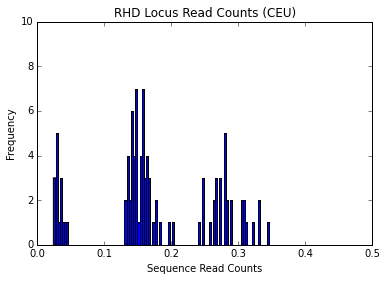

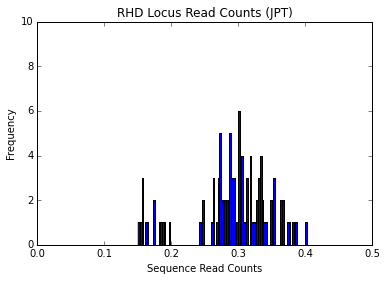

In [57]:
plt.hist(rhdListCEU, bins=100)
plt.title("RHD Locus Read Counts (CEU)")
plt.xlabel("Sequence Read Counts")
plt.ylabel("Frequency")
plt.axis([0, 0.5, 0, 10]) #put on same axis
plt.show()

plt.hist(rhdListJPT, bins=100)
plt.title("RHD Locus Read Counts (JPT)")
plt.xlabel("Sequence Read Counts")
plt.ylabel("Frequency")
plt.axis([0, 0.5, 0, 10])
plt.show()